In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid', context='notebook', palette='deep',
        font_scale=2, rc={'figure.figsize': [12, 8]})

### Homogeneous Poisson Point Process

Transaction times :
TimedeltaIndex([ '0 days 00:01:09.724800',  '0 days 00:05:58.646400',
                 '0 days 00:06:02.534400',  '0 days 00:06:48.153600',
                 '0 days 00:07:16.060800',  '0 days 00:16:03.014400',
                 '0 days 00:18:12.873600',  '0 days 00:20:15.388800',
                 '0 days 00:24:23.702400',  '0 days 00:35:43.238400',
                ...
                '99 days 07:01:07.248000', '99 days 07:04:03.504000',
                '99 days 07:07:11.769600', '99 days 07:09:15.235200',
                '99 days 07:13:20.092800', '99 days 07:13:45.235200',
                '99 days 07:16:37.603200', '99 days 07:17:21.580800',
                '99 days 07:18:09.705600', '99 days 07:18:18.345600'],
               dtype='timedelta64[ns]', length=50000, freq=None)
Mean : 503.4646464646465
Variance : 587.1288394145538



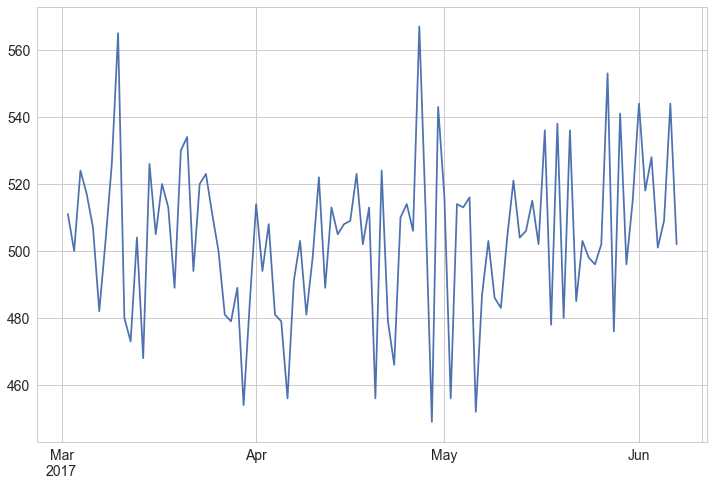

In [2]:
def hpp(λ, n, t0, freq=None, verbose=False):
    """
    Homogeneous Poisson Point Process
    
    Parameters
    ----------
    λ : Poisson rate parameter [transactions per day]
    n : number of transactions to produce
    t0 : initial datetime for simulation
    freq : Pandas resample rule for returned time series
    
    Returns
    -------
    Time series of transactions per freq
    """
    # Times between Poisson-distributed events are exponentially distributed with mean 1 / λ
    transaction_times = pd.TimedeltaIndex(np.cumsum(np.random.exponential(1 / λ, n)), unit='d')
    # Generate non-grouped HPP
    transactions = pd.Series(data=1, 
                             index=pd.to_datetime(t0) + transaction_times, 
                             name='transactions')
    # Check mean and variance to ensure this is Poisson-like
    if verbose:
        transactions_check = transactions.resample('1D').sum().fillna(0)[:-1]
        print('Transaction times :')
        print(transaction_times)
        print('Mean : {}'.format(transactions_check.mean()))
        print('Variance : {}'.format(transactions_check.var()))
        print()
    # Group transactions by freq
    if freq:
        transactions = transactions.resample(freq).sum().fillna(0)[1:-1]

    return transactions


ts_hpp = hpp(λ=500, n=int(50000), t0='2017-03-01', freq='1D', verbose=True) 
ts_hpp.plot(figsize=(12, 8), fontsize=14)

Mean : 499.03061224489795
Variance : 486.4423521986115


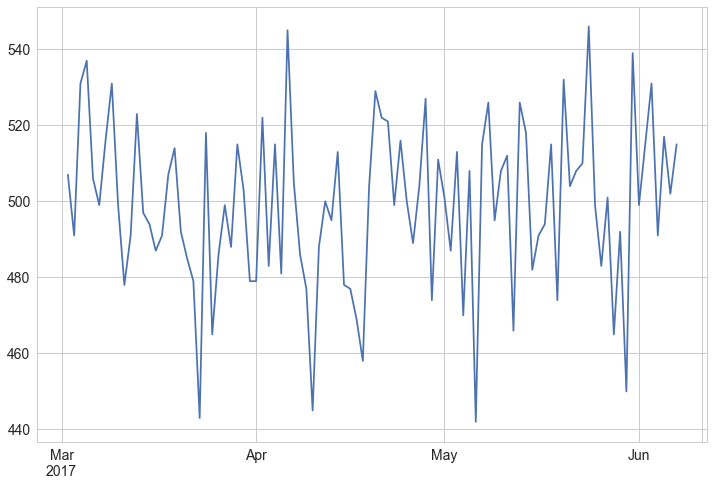

In [3]:
# Check against series generated from Poisson distribution
transactions_check = pd.Series(data=np.random.poisson(500, len(ts_hpp)),
                               index=ts_hpp.index)

# Check mean and variance to ensure this is Poisson-like
print('Mean : {}'.format(transactions_check.mean()))
print('Variance : {}'.format(transactions_check.var()))

transactions_check.plot(figsize=(12, 8), fontsize=14)

### Thinning Function

In [4]:
def _trend(t, params):
    """
    Trend component for time series decomposition
    Modeled as exponential growth relative to unity at some t_min
    
    params : {
        'percent_increase' : number between [0, 1] quantifying growth rate
        'period' : the time (in days) over which percent_increase applies
        }
    """
    relative_time = (t - t.round('D').min()) / np.timedelta64(1, 'D')
    y = np.power(1 + params['percent_increase'], relative_time / params['period'])
    return y / max(y)


def _cyclical(t, params):
    """
    Cyclical component for time series decomposition
    Modeled as a fractional damping applied to a given day of week

    params : {
        'weekday_factor': list (len=7) mapping weekday to reduction between [0, 1] applied to rate
                           value corresponding to Monday is in 0-index of weekday_factor
        }
    """
    y = pd.Index(t.weekday.to_series().map({k: params['weekday_factor'][k] for k in range(7)}))
    return y / max(y)


def _seasonal(t, params):
    """
    Seasonal component for time series decomposition
    Modeled as a sine with 1-day period, amplitude between [0, 1], constrained to unity at peak

    params : {
        'peak_time' : time (str or pd.datetime) at which _seasonal is defined to be 1
        'amplitude' : number between [0, 1] dictating the percent reduction at min
        }
    """  
    relative_time = (t - pd.to_datetime(params['peak_time'])).seconds / (24 * 60 * 60)
    y = 1 - params['amplitude'] * (1 + np.sin(2 * np.pi * relative_time)) / 2
    return y / max(y)


In [5]:
def thinning(t, components):
    """
    Thinning function used to accept or reject Homogeneous Poisson Point Process events.
    Functions in components are combined multiplicatively and must be strictly positive.
    Resulting composite is scaled to be bound by [0, 1]
        0 --> instantaneous Poisson rate = 0 in the Nonhomogeneous Process
        1 --> instantaneous Poisson rate = rate of Homogeneous Process in the Nonhomogeneous Process
    
    Parameters
    ----------
    t : interable containing datetimes for the time series
    components : list of dicts with entries: 
                     'function': function to be applied  [required]
                     'params': dict with required parameters for function  [optional]
                 e.g. components = [
                     {'function': func1, 'args': (1, 'foo')},
                     {'function': func2, 'kwargs': {'p3': 'bar', 'p4': None}}
                     ]
                 where
                 def func1(t, p1, p2):  <-- p1=1, p2='foo'
                     ...
                 and
                 def func2(t, p3, p4):  <-- p3='bar', p4=None
                     ...
                     
    Returns
    _______
    Pandas series with index t and values [0, 1] corresponding to thinning to be applied.
    """
    y = pd.Series(1, index=t, name='thinning')
    for comp in components:
        y *= comp['function'](t, comp['params'])
    return y


[Text(0,0.5,'r(t)')]

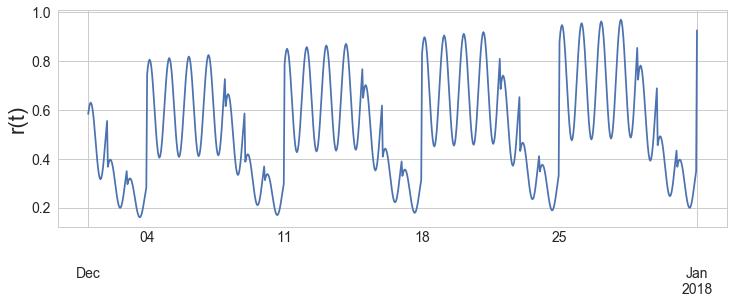

In [131]:
y = thinning(
    t=pd.date_range('2017-12-01', '2018-01-01', freq='1H'), 
    components=[
    {'function': _trend, 'params': {'percent_increase': 1.0, 'period': 90}},
    {'function': _cyclical, 'params': {'weekday_factor': [1, 1, 1, 1, 0.8, 0.5, 0.4]}},
    {'function': _seasonal, 'params': {'peak_time': '09:00:00', 'amplitude': 0.5}}])
ax = y.plot(figsize=(12, 4), fontsize=14)
ax.set(ylabel='r(t)')

### Nonhomogeneous Poisson Point Process

In [7]:
def nhpp(λ, n, t0, freq=None, thinning_components=None):
    """
    Nonhomogeneous Poisson Point Process
    
    Parameters
    ----------
    λ : Poisson rate parameter [transactions per day] of the bounding Homogeneous Point Process
        Equal to the instantaneous rate of the Nonhomogeneous Point Process when thinning = 1
    n : number of transactions to produce
    t0 : initial datetime for simulation
    freq : Pandas resample rule for returned time series
    thinning_components : components to pass to thinning function
    
    Returns
    -------
    Time series of transactions per freq
    """
    # Get a non-grouped HPP
    transactions = hpp(λ, n, t0)
    # Thin the HPP
    if thinning_components:
        transactions = transactions[np.random.uniform(size=len(transactions)) < 
                                    thinning(t=transactions.index, components=thinning_components)]
    # Group transactions by freq
    if freq:
        transactions = transactions.resample(freq).sum().fillna(0)[1:-1]

    return transactions


[Text(0,0.5,'Transactions')]

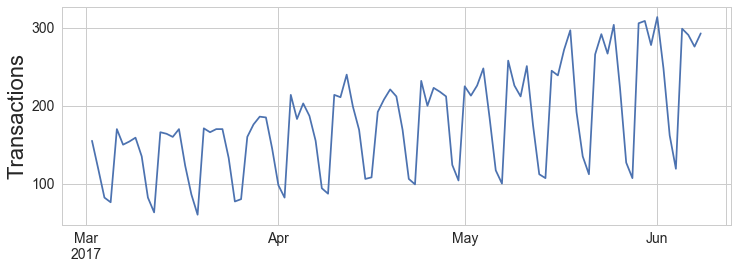

In [132]:
λ = 500  
n = int(50000)  
t0 = pd.to_datetime('2017-03-01') 
freq = '1D'
thinning_components = [
    {'function': _trend, 'params': {'percent_increase': 1.0, 'period': 90}},
    {'function': _cyclical, 'params': {'weekday_factor': [1, 1, 1, 1, 0.8, 0.5, 0.4]}},
    {'function': _seasonal, 'params': {'peak_time': '09:00:00', 'amplitude': 0.75}}]

ts_hpp = hpp(λ, n, t0, freq)
ts_nhpp = nhpp(λ, n, t0, freq, thinning_components)

# ts_hpp.plot(figsize=(12, 8), fontsize=14)
ax = ts_nhpp.plot(figsize=(12, 4), fontsize=14)
ax.set(ylabel='Transactions')

''

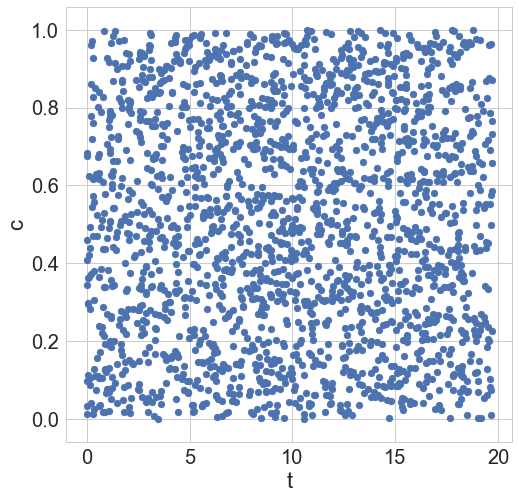

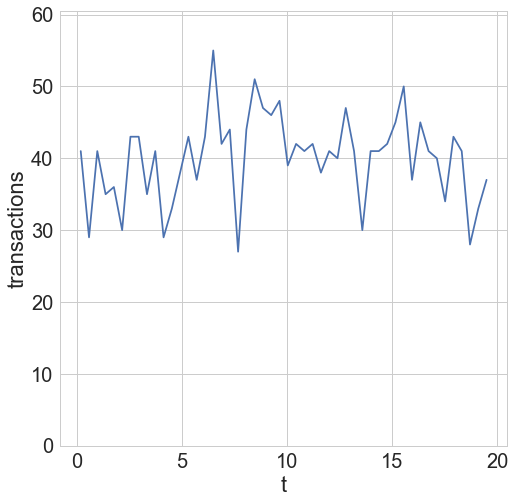

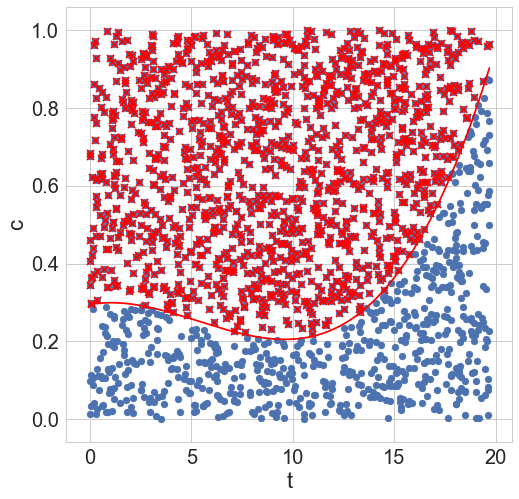

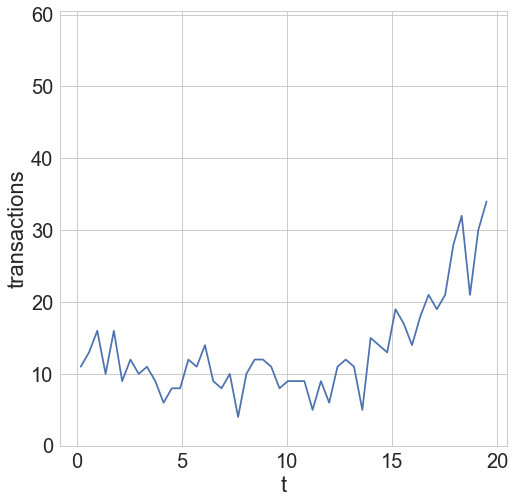

In [122]:
import matplotlib.pyplot as plt
sns.set(style='whitegrid', context='notebook', palette='deep',
        font_scale=2, rc={'figure.figsize': [8, 8]})

λ = 100
n = int(2000) 

pp = np.cumsum(np.random.exponential(1 / λ, n))
xx = np.linspace(0, max(pp), 1000)
c = np.random.uniform(size=n)

fig, ax = plt.subplots(1, 1) 
ax.scatter(pp, c)
ax.set(xlabel='t', ylabel='c')

h, b = np.histogram(pp, bins=50)
xb = (b[:-1] + b[1:]) / 2

fig, ax = plt.subplots(1, 1) 
ax.plot(xb, h)
ax.set(xlabel='t', ylabel='transactions')
ax.set_ylim([0, max(h) * 1.1])

def r(x):
    return 0.0003 * (x - 2)**3 - .003 * (x - 1)**2 - .0005 * x + 0.3

fig, ax = plt.subplots(1, 1) 
ax.scatter(pp, c)
ax.plot(xx, r(xx), '-r')
ax.scatter(pp[c > r(pp)], c[c > r(pp)], marker='x', c='r')
ax.set(xlabel='t', ylabel='c')

hn, b = np.histogram(pp[c <= r(pp)], bins=b)

fig, ax = plt.subplots(1, 1) 
ax.plot(xb, hn)
ax.set(xlabel='t', ylabel='transactions')
ax.set_ylim([0, max(h) * 1.1])

''